In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import os
import datetime
from datetime import datetime as dt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

Data Load

In [88]:
data_path = "/root/storage/etri_lifelog/user01-06/user06"
dir_list = os.listdir(data_path)

user_all_data = []

for item in dir_list:
    csv_file = data_path + "/" + item + "/" + item + "_label.csv"
    rdr = pd.read_csv(csv_file)
    user_all_data.append(rdr)


#df_all : 전체 data
df_all = pd.concat(user_all_data, axis=0)
df_all['ts']=pd.to_datetime(df_all['ts'], unit='s')
df_all['is_weekend']=df_all.apply(lambda x: x['ts'].weekday()>=5, axis=1)
df_all['ampm']=df_all.apply(lambda x: ["AM","PM"][x['ts'].hour//12], axis=1)


df_no_dup = df_all.drop_duplicates()

#df_sort : 연속된 동일한 actionOption끼리 묶음
diff_indices = [0]
diff_index = 0
df_sort = pd.DataFrame()
for i in range(len(df_no_dup)):
    if(df_no_dup['actionOption'].values[i]!=df_no_dup['actionOption'].values[diff_index]):
        diff_index=i
        diff_indices.append(diff_index)
        #df_sort = df_no_dup.iloc[i:i+1]
        df_sort = df_sort.append(pd.Series(df_no_dup.iloc[i], index=df_no_dup.columns), ignore_index=True)


actionOption_dict = {'111': 'Sleep', '112': 'Sleepless', '121': 'Meal', '122': 'Snack', '131': 'Medical services, treatments, sick rest', '132': 'Personal hygiene (bath)', '133': 'Appearance management (makeup, change of clothes)', '134': 'Beauty-related services', '211': 'Main job', '212': 'Side job', '213': 'Rest during work', '22': 'Job search', '311': 'School class / seminar (listening)', '312': 'Break between classes', '313': 'School homework, self-study (individual)', '314': 'Team project (in groups)', '321': 'Private tutoring (offline)', '322': 'Online courses', '41': 'Preparing food and washing dishes', '42': 'Laundry and ironing', '43': 'Housing management and cleaning', '44': 'Vehicle management', '45': 'Pet and plant caring', '46': 'Purchasing goods and services (grocery/take-out)', '51': 'Caring for children under 10 who live together', '52': 'Caring for elementary, middle, and high school students over 10 who live together', '53': 'Caring for a spouse', '54': 'Caring for parents and grandparents who live together', '55': 'Caring for other family members who live together', '56': 'Caring for parents and grandparents who do not live together', '57': 'Caring for other family members who do not live together', '81': 'Personal care-related travel', '82': 'Commuting and work-related travel', '83': 'Education-related travel', '84': 'Travel related to housing management', '85': 'Travel related to caring for family and household members', '86': 'Travel related to participation and volunteering', '87': 'Socializing and leisure-related travel', '61': 'Religious activities', '62': 'Political activity', '63': 'Ceremonial activities', '64': 'Volunteer', '711': 'Offline communication', '712': 'Video or voice call', '713': 'Text or email (Online)', '721': 'Reading books, newspapers, and magazines', '722': 'Watching TV or video', '723': 'Listening to audio', '724': 'Internet search or blogging', '725': 'Gaming (mobile, computer, video)', '741': 'Watching a sporting event', '742': 'Watching movie', '743': 'Concerts and plays', '744': 'Amusement Park, zoo', '745': 'Festival, carnival', '746': 'Driving, sightseeing, excursion', '751': 'Walking', '752': 'Running, jogging', '753': 'Climbing, hiking', '754': 'Biking', '755': 'Ball games (soccer, basketball, baseball, tennis, etc)', '756': 'Camping, fishing', '761': 'Group games (board games, card games, puzzles, etc.)', '762': 'Personal hobbies (woodworking, gardening, etc.)', '763': 'Group performances (orchestra, choir, troupe, etc.)', '764': 'Liberal arts and learning (languages, musical instruments, etc.)', '791': 'Nightlife', '792': 'Smoking', '793': 'Do nothing and rest', '91': 'Online shopping', '92': 'Offline shopping'}





One Hot Encoding

In [89]:
import torch
import torch.nn.functional as F

def dfToTensor(df, list_attributes):
    # 한 사람의 전체 label dataframe과 index tensor로 만들고 싶은 attribute들의 리스트를 입력해주면 각각의 index tensor들이 담긴 list를 반환
    attribute_tensors = []
    for attribute in list_attributes:
        type_attributes = list(df_all[attribute].drop_duplicates())
        tensor = torch.Tensor([x for x in df.apply(lambda x: type_attributes.index(x[attribute]), axis=1)]).to(torch.int64)
        attribute_tensors.append(tensor)
    return attribute_tensors

def indexToOneHot(attribute_tensors):
    # index tensor들이 담긴 list를 입력해주면 one hot으로 변환한 tensor들을 담은 list를 반환
    return([F.one_hot(x) for x in attribute_tensors])

# 하나의 Tensor가 아니라 list로 주는 이유는 좀더 가공하기 편하기 위함, 해당 함수들에 사용되는 attribute는 categorical 데이터만 사용.
#print(indexToOneHot(dfToTensor(df_all, ['action', 'place'])))
    

    

Data

In [91]:
onehot_x = indexToOneHot(dfToTensor(df_sort,['actionOption']))[0]

train_size = int(len(onehot_x) * 0.67)
test_size = len(onehot_x) - train_size

dataX = Variable(onehot_x)
dataY = Variable(onehot_x[1:])
dataY_l = torch.argmax(dataY,dim =-1)


trainX = Variable(torch.Tensor(np.array(onehot_x[0:train_size-1])))
trainY = Variable(torch.Tensor(np.array(onehot_x[1:train_size])))
trainY_l = torch.argmax(trainY,dim =-1)


testX = Variable(torch.Tensor(np.array(onehot_x[train_size:len(onehot_x)])))
testY = Variable(torch.Tensor(np.array(onehot_x[train_size:len(onehot_x)])))
testY_l = torch.argmax(testY,dim =-1)


dataX = torch.unsqueeze(dataX,1)
trainX = torch.unsqueeze(trainX,1)
testX = torch.unsqueeze(testX,1)
#print(trainX.shape)
#print(dataX.shape)



Model

In [92]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out



Train

Epoch: 0, loss: 3.50048
Epoch: 100, loss: 2.58200
Epoch: 200, loss: 2.32840
Epoch: 300, loss: 2.18853
Epoch: 400, loss: 2.08549
Epoch: 500, loss: 2.00546
Epoch: 600, loss: 1.95592
Epoch: 700, loss: 1.92969
Epoch: 800, loss: 1.91026
Epoch: 900, loss: 1.89780
Epoch: 1000, loss: 1.88878
Epoch: 1100, loss: 1.88208
Epoch: 1200, loss: 1.87668
Epoch: 1300, loss: 1.87187
Epoch: 1400, loss: 1.86646
Epoch: 1500, loss: 1.85924
Epoch: 1600, loss: 1.85445
Epoch: 1700, loss: 1.85078
Epoch: 1800, loss: 1.84768
Epoch: 1900, loss: 1.84497


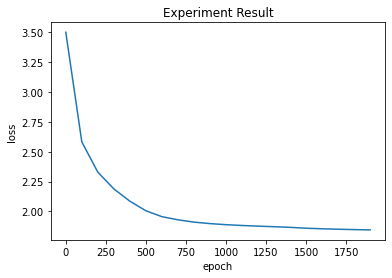

tensor([[ 4.2404,  2.0108, -0.5166,  ..., -3.8382, -3.3144, -3.4056],
        [ 2.9072, -1.4072,  0.4249,  ..., -4.5215, -4.0598, -4.1242],
        [ 7.1773, 10.6777, -3.6274,  ..., -1.8310, -1.1180, -1.3086],
        ...,
        [ 4.2404,  2.0108, -0.5166,  ..., -3.8382, -3.3144, -3.4056],
        [ 5.9068,  5.6483, -1.1144,  ..., -3.2642, -2.6922, -2.7942],
        [ 2.7904, -1.6113,  0.4204,  ..., -4.5393, -4.0785, -4.1441]],
       grad_fn=<AddmmBackward0>)
tensor([ 0,  2,  1,  3,  0,  4,  5,  0,  5,  6,  0,  5,  3,  7,  8,  9, 10,  9,
        10,  9, 10,  9, 10,  9,  8, 11,  3, 12,  5,  7,  8,  9,  3,  9, 10,  9,
         8,  0, 11,  3,  0, 12, 13,  7, 14,  1, 15, 14,  1,  3, 12, 16, 12,  5,
         3,  5,  1,  3,  7,  8, 17,  3,  0, 17,  1, 17,  0,  5, 17,  8,  3, 11,
         5,  3,  7, 18, 19, 18,  1,  0, 13,  0, 13,  0,  3,  5,  0, 13,  3,  8,
         9, 10,  9, 10,  9, 10,  9, 10,  8,  0, 11,  3,  1,  0, 16,  5,  7,  8,
         9,  8, 15,  8,  3, 11,  5,  6,  5, 12, 13,  

In [112]:
num_epochs = 2000
learning_rate = 0.01

input_size = len(onehot_x[0])
hidden_size = 2
num_layers = 1
num_classes = len(onehot_x[0])

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)


#classfication
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


loss_ = [0]
epoch_ = [0]

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY_l)      #trainY one-hot index
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      loss_.append(loss.item())
      epoch_.append(epoch)
   
plt.plot(epoch_[1:],loss_[1:])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Experiment Result')
plt.show()


print(outputs)
print(trainY_l)



Test

[[ 0.13477945 -2.5328255  -3.072668   ... -3.3032835  -2.693624
  -2.9162734 ]
 [ 2.009402   -2.5862303   0.03553748 ... -4.4869437  -4.014967
  -4.1015654 ]
 [ 4.416086    2.4056468  -0.59016395 ... -3.7731614  -3.2437437
  -3.3364887 ]
 ...
 [ 5.906397    5.6426334  -1.1106426  ... -3.2668009  -2.6950645
  -2.7968264 ]
 [ 3.1622806  -1.0214888   0.48975706 ... -4.509802   -4.048561
  -4.1085715 ]
 [ 5.906397    5.6426334  -1.1106426  ... -3.2668009  -2.6950645
  -2.7968264 ]]


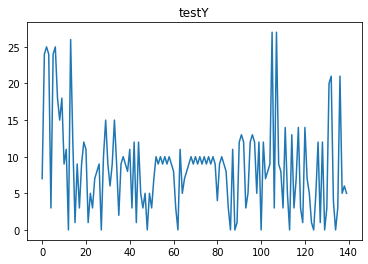

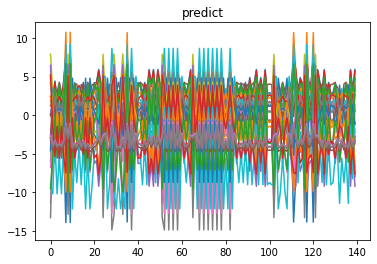

In [117]:
#sc = MinMaxScaler()

lstm.eval()
train_predict = lstm(testX)

#accuracy
data_predict = train_predict.data.numpy()
testY_plot = testY_l.data.numpy()

print(data_predict)

#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(testY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(testY_plot)
plt.title('testY')
plt.show()

plt.plot(data_predict)
plt.title('predict')
plt.show()



